# MODELING V1 FEB19

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def max_pooling_batch(matrices, new_shape):
    original_batch, original_height, original_width = matrices.shape  
    target_height, target_width = new_shape
    pool_size = original_width // target_width  # 29640 // 120 = 247
    reshaped = matrices.reshape(original_batch, original_height, target_width, pool_size)
    pooled = np.max(reshaped, axis=3)
    return pooled 

In [3]:
def count_and_percentage(array):
    flattened = array.flatten()
    unique, counts = np.unique(flattened, return_counts=True)
    total_elements = flattened.size
    count_dict = dict(zip(unique, counts))
    percentage_dict = {key: (value / total_elements) * 100 for key, value in count_dict.items()}
    return count_dict, percentage_dict

In [4]:
#############################
# 1. Data Preprocessing
#############################
#Loading Data (Vegetation, Elevation and the Labels
elevation_data = np.load('elevation_matrix.npy') #1 channel
vegetation_data = np.load('NLCD2021_OR.npy') # 15 channels
label = np.load('landslide_labels_stored_sequentially_compressed.npz') 
output_labels = label['matrix']
labels_resized = max_pooling_batch(output_labels, (120, 120))  # Output shape: (1096, 120, 120)
counts, percentages = count_and_percentage(labels_resized)
print("Counts:", counts)  
print("Percentages:", percentages)

#Preparing the Soil Variable Data
directory = "ERA5_matrices"  
npy_files = sorted([f for f in os.listdir(directory) if f.endswith('.npy')])
matrices = [np.load(os.path.join(directory, file)) for file in npy_files]
data = np.stack(matrices, axis=0)  # Shape: (num_files, height, width)
soil_variable_data = np.transpose(data, (1, 0, 2, 3)) 

#Preparing the Soil Composition Data
data_folder = "SOLUS"
npy_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]
num_files = len(npy_files)
transformed_data_list = []
pca = PCA(n_components=1)
for file in npy_files:
    file_path = os.path.join(data_folder, file)
    soil_data = np.load(file_path)
    reshaped_data = soil_data.reshape(7, -1).T
    principal_component = pca.fit_transform(reshaped_data)  # Shape: (1306*464, 1)
    reduced_data = principal_component.reshape(1306, 464)
    transformed_data_list.append(reduced_data)

soil_composition_data = np.stack(transformed_data_list, axis=0)  # Shape: (18, 1306, 464)

vegetation_data = torch.tensor(vegetation_data, dtype=torch.float)         # (15, 4353, 1547)
elevation_data = torch.tensor(elevation_data, dtype=torch.float).unsqueeze(0)            # (1, 10812, 10812)
soil_composition_data = torch.tensor(soil_composition_data, dtype=torch.float)  # (18, 1306, 464)
soil_variable_data = torch.tensor(soil_variable_data, dtype=torch.float)     # (1096, 28, 5, 5)
output_labels = torch.tensor(labels_resized, dtype=torch.long)                # (1096, 120, 29640)

# Define the target spatial resolution (here, same as output labels)
target_size = (120, 120)  # (height, width)

# Define a helper function to resize a (C, H, W) tensor to a given target_size.
def resize_tensor_bilinear(tensor, target_size, mode='bilinear'):
    """
    Resizes a tensor of shape (C, H, W) to (C, target_H, target_W) using interpolation.
    """
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode, align_corners=False)
    return resized.squeeze(0)

def resize_tensor_nearest(tensor, target_size, mode='nearest'):
    """
    Resizes a tensor of shape (C, H, W) to (C, target_H, target_W) using interpolation.
    """
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode)
    return resized.squeeze(0)

def normalize_tensor(tensor, eps=1e-8):
    """
    Normalize a tensor to the range [0, 1].
    
    Args:
        tensor (torch.Tensor): The input tensor.
        eps (float): A small value to prevent division by zero in case the tensor is constant.
    
    Returns:
        torch.Tensor: The normalized tensor.
    """
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized = (tensor - min_val) / (max_val - min_val + eps)
    return normalized

# Pre-resize the static datasets (they do not change by day)
vegetation_resized = resize_tensor_nearest(vegetation_data, target_size)       # -> (15, 120, 29640)
elevation_resized_ = resize_tensor_bilinear(elevation_data, target_size)           # -> (1, 120, 29640)
soil_composition_resized_ = resize_tensor_bilinear(soil_composition_data, target_size)  # -> (18, 120, 29640)

elevation_resized = normalize_tensor(elevation_resized_)
soil_composition_resized = normalize_tensor(soil_composition_resized_)

print(vegetation_resized.shape)
print(elevation_resized.shape)
print(soil_composition_resized.shape)
print(output_labels.shape)

Counts: {0.0: 15118676, 1.0: 303439, 2.0: 360285}
Percentages: {0.0: 95.79453061638281, 1.0: 1.9226416768045418, 2.0: 2.282827706812652}
torch.Size([15, 120, 120])
torch.Size([1, 120, 120])
torch.Size([18, 120, 120])
torch.Size([1096, 120, 120])


In [5]:
#############################
# 2. Create a Custom Dataset
#############################

class DayDataset(Dataset):
    """
    Custom dataset that for each day returns a multi-channel input (concatenated from the static data
    and that day’s soil variable data) and the corresponding output label.
    """
    def __init__(self, day_indices, vegetation, elevation, soil_comp, soil_var, labels, target_size):
        """
        Args:
          day_indices: list of day indices (e.g., [0, 1, 2, ...])
          vegetation: static vegetation data, already resized, shape (15, target_H, target_W)
          elevation: static elevation data, already resized, shape (1, target_H, target_W)
          soil_comp: static soil composition data, already resized, shape (18, target_H, target_W)
          soil_var: daily soil variable data, shape (1096, 28, 5, 5)
          labels: daily output labels, shape (1096, target_H, target_W)
          target_size: the target spatial size (target_H, target_W) for all inputs
        """
        self.day_indices = day_indices
        self.vegetation = vegetation
        self.elevation = elevation
        self.soil_comp = soil_comp
        self.soil_var = soil_var
        self.labels = labels
        self.target_size = target_size

    def __len__(self):
        return len(self.day_indices)

    def __getitem__(self, idx):
        day = self.day_indices[idx]
        # Get the soil variable data for this day (shape: (28, 5, 5)) and resize it
        soil_var_day = self.soil_var[day]  # (28, 5, 5)
        soil_var_day_resized_ = resize_tensor_bilinear(soil_var_day, self.target_size)# (28, 120, 29640)
        soil_var_day_resized = normalize_tensor(soil_var_day_resized_)

        # Concatenate along the channel dimension.
        # Total input channels = 15 + 1 + 18 + 28 = 62.
        input_tensor = torch.cat([self.vegetation, self.elevation, self.soil_comp, soil_var_day_resized], dim=0)
        # Get the label for this day: shape (120, 29640)
        label = self.labels[day]
        return input_tensor, label

# Create day indices. According to your plan:
# Train on the first 730 days, test on the rest 366 days.
all_days = list(range(1096))
train_days = list(range(0, 730))
test_days = list(range(730, 1096))
# Optionally, you can further split a small validation set out of the training days.
val_days = train_days[-100:]   # e.g., last 100 days for validation
train_days = train_days[:-100]  # remaining days for training

# Create the datasets
train_dataset = DayDataset(train_days, vegetation_resized, elevation_resized,
                           soil_composition_resized, soil_variable_data, output_labels, target_size)
val_dataset = DayDataset(val_days, vegetation_resized, elevation_resized,
                         soil_composition_resized, soil_variable_data, output_labels, target_size)
test_dataset = DayDataset(test_days, vegetation_resized, elevation_resized,
                          soil_composition_resized, soil_variable_data, output_labels, target_size)

# Create DataLoaders (adjust batch_size as appropriate; note that these “images” are huge!)
batch_size = 16  # often you need a small batch size with large spatial data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#############################
# 3. Define the FCN Model
#############################
#############################
# 3. Define the FCN Model
#############################
class FCN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        A simple encoder-decoder Fully Convolutional Network.
        Args:
          in_channels: number of input channels (here, 62)
          num_classes: number of output classes (here, 3 for labels 0, 1, 2)
        """
        super(FCN, self).__init__()
        # Encoder: three conv layers with pooling
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # downsamples by factor 2

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Decoder: upsampling via transpose convolutions
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))    # (64, H, W)
        x = self.pool1(x)                      # (64, H/2, W/2)

        x = F.relu(self.bn2(self.conv2(x)))    # (128, H/2, W/2)
        x = self.pool2(x)                      # (128, H/4, W/4)

        x = F.relu(self.bn3(self.conv3(x)))    # (256, H/4, W/4)
        x = self.pool3(x)                      # (256, H/8, W/8)

        # Decoder (upsample back to original resolution)
        x = self.upconv1(x)                    # (128, H/4, W/4)
        x = self.upconv2(x)                    # (64, H/2, W/2)
        x = self.upconv3(x)                    # (num_classes, H, W)
        return x

# Instantiate the model
in_channels = 15 + 1 + 18 + 28  # 62 channels total
num_classes = 3
model = FCN(in_channels, num_classes)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/shelly/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


FCN(
  (conv1): Conv2d(62, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (upconv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)

Epoch 1/100  Train Loss: 1.0218  Val Loss: 1.0261
Epoch 2/100  Train Loss: 0.8393  Val Loss: 0.7710
Epoch 3/100  Train Loss: 0.7210  Val Loss: 0.7125
Epoch 4/100  Train Loss: 0.6749  Val Loss: 0.7084
Epoch 5/100  Train Loss: 0.6553  Val Loss: 0.7160
Epoch 6/100  Train Loss: 0.6435  Val Loss: 0.6546
Epoch 7/100  Train Loss: 0.6355  Val Loss: 0.7135
Epoch 8/100  Train Loss: 0.6306  Val Loss: 0.6473
Epoch 9/100  Train Loss: 0.6279  Val Loss: 0.6963
Epoch 10/100  Train Loss: 0.6257  Val Loss: 0.6565
Epoch 11/100  Train Loss: 0.6213  Val Loss: 0.6559
Epoch 12/100  Train Loss: 0.6193  Val Loss: 0.6494
Epoch 13/100  Train Loss: 0.6141  Val Loss: 0.7467
Epoch 14/100  Train Loss: 0.6097  Val Loss: 0.6657
Epoch 15/100  Train Loss: 0.6075  Val Loss: 0.6067
Epoch 16/100  Train Loss: 0.6060  Val Loss: 0.6830
Epoch 17/100  Train Loss: 0.6018  Val Loss: 0.7506
Epoch 18/100  Train Loss: 0.6025  Val Loss: 0.6095
Epoch 19/100  Train Loss: 0.5952  Val Loss: 0.6701
Epoch 20/100  Train Loss: 0.5961  Val Lo

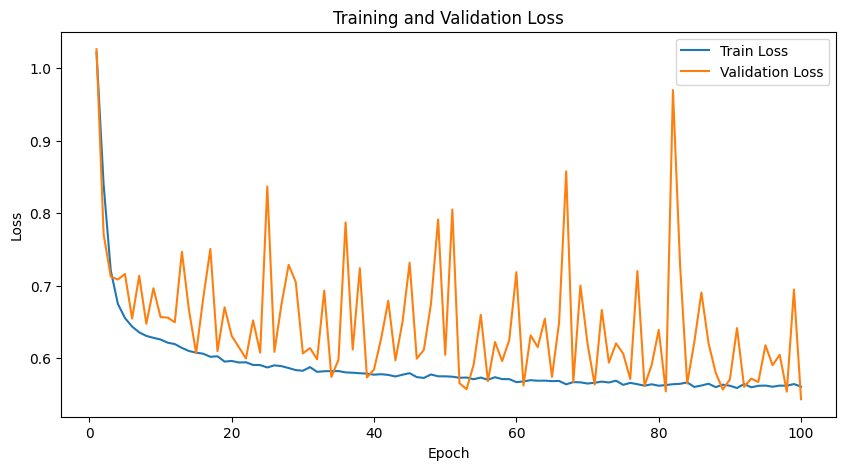

In [7]:
#############################
# 4. Train the Model
#############################
freq = torch.tensor([0.9579453061638281, 0.019226416768045418, 0.02282827706812652])
weights = 1.0 / freq
weights = weights / weights.sum()
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)  # expects outputs of shape (N, C, H, W) and target of shape (N, H, W)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)   # shape: (B, 62, 120, 120)
        labels = labels.to(device)   # shape: (B, 120, 120)

        optimizer.zero_grad()
        outputs = model(inputs)      # shape: (B, 3, 120, 120)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")

# Plotting the losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# #############################
# # 5. Testing
# #############################
# model.eval() 
# test_loss = 0.0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         test_loss += loss.item() * inputs.size(0)
# test_loss = test_loss / len(test_dataset)
# print(f"Test Loss: {test_loss:.4f}")


In [11]:
def compute_iou(pred, target, num_classes=3):
    """
    Compute the Intersection over Union (IoU) for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: IoU for each class.
    """
    ious = []
    # Flatten the tensors for easier computation.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious.append(float('nan'))  # Alternatively, you might want to append 0.0
        else:
            ious.append((intersection / union).item())
    return ious

def compute_dice(pred, target, num_classes=3):
    """
    Compute the Dice coefficient for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: Dice coefficient for each class.
    """
    dices = []
    # Flatten the tensors.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()
        if total == 0:
            dices.append(float('nan'))
        else:
            dices.append((2 * intersection / total).item())
    return dices

def compute_confusion_matrix(pred, target, num_classes=3):
    """
    Compute a confusion matrix where the rows correspond to true classes
    and the columns correspond to predicted classes.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      torch.Tensor: A (num_classes, num_classes) confusion matrix.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    # Use torch.bincount to count occurrences of each (true, pred) pair.
    cm = torch.bincount(num_classes * target + pred, minlength=num_classes**2)
    cm = cm.reshape(num_classes, num_classes)
    return cm

def compute_precision_recall_f1(conf_matrix):
    """
    Compute per-class precision, recall, and F1 score from a confusion matrix.
    Args:
      conf_matrix (torch.Tensor): A (num_classes, num_classes) confusion matrix.
    Returns:
      tuple: Three lists containing precision, recall, and F1 score for each class.
    """
    num_classes = conf_matrix.shape[0]
    precisions = []
    recalls = []
    f1s = []
    for i in range(num_classes):
        TP = conf_matrix[i, i].item()
        FP = conf_matrix[:, i].sum().item() - TP
        FN = conf_matrix[i, :].sum().item() - TP
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
        recall    = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else float('nan')
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

In [1]:
# model.eval()
# test_loss = 0.0
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         test_loss += loss.item() * inputs.size(0)
        
#         # Convert raw logits to predicted class labels (shape: (batch_size, H, W))
#         preds = torch.argmax(outputs, dim=1)
        
#         # Collect predictions and ground truth labels for metric computations
#         all_preds.append(preds.cpu())
#         all_labels.append(labels.cpu())

# # Calculate average test loss over the dataset
# test_loss = test_loss / len(test_dataset)
# print(f"Test Loss: {test_loss:.4f}")

# # Concatenate all the collected predictions and labels along the batch dimension
# all_preds = torch.cat(all_preds, dim=0)
# all_labels = torch.cat(all_labels, dim=0)

# # Compute metrics using the functions defined earlier
# ious = compute_iou(all_preds, all_labels, num_classes=3)
# dices = compute_dice(all_preds, all_labels, num_classes=3)
# conf_matrix = compute_confusion_matrix(all_preds, all_labels, num_classes=3)
# precisions, recalls, f1s = compute_precision_recall_f1(conf_matrix)

# print("IoU per class:", ious)
# print("Dice per class:", dices)
# print("Confusion Matrix:\n", conf_matrix)
# print("Precision per class:", precisions)
# print("Recall per class:", recalls)
# print("F1 per class:", f1s)
